# 0. Install and Import Dependencies

In [1]:
!pip list



Package                           Version
--------------------------------- ------------------
absl-py                           2.1.0
aiobotocore                       2.12.3
aiohappyeyeballs                  2.4.0
aiohttp                           3.10.5
aioitertools                      0.7.1
aiosignal                         1.2.0
alabaster                         0.7.16
altair                            5.0.1
anaconda-anon-usage               0.4.4
anaconda-catalogs                 0.2.0
anaconda-cli-base                 0.4.1
anaconda-client                   1.13.0
anaconda-cloud-auth               0.7.2
anaconda-navigator                2.6.4
anaconda-project                  0.11.1
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
archspec                          0.2.3
argon2-cffi                       21.3.0
argon2-cffi-bindings              21.2.0
arrow                             1.2.3
astroid           

In [2]:
!pip install opencv-python matplotlib imageio gdown tensorflow


In [3]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [4]:
tf.config.list_physical_devices('GPU')

[]

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [6]:
import gdown

In [7]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=008ca33f-5512-4b0d-9dee-e74e6b9207a5
To: C:\Users\jdaphne\Desktop\LipReadingAI\data.zip
100%|███████████████████████████████████████████████████████████████████████████████| 423M/423M [00:19<00:00, 21.3MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [8]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path) #looping through every single video.
    frames = [] #storing the frames into our own set of array.
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):  
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame) #conversion so that there is less data to process.
        frames.append(frame[190:236,80:220,:]) #isolating the mouth - can use dlib ( a face detector) instead like in the LipNet paper.
    cap.release()
    
    #standardizing
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32)) #scaling data.
    return tf.cast((frames - mean), tf.float32) / std #cast to float.

In [9]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]  #defining vocab

In [10]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="") #character to number
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)  #num to char

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [11]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [12]:
char_to_num(['j','e','s','i'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([10,  5, 19,  9], dtype=int64)>

In [13]:
num_to_char([10,  5,  19, 9])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'j', b'e', b's', b'i'], dtype=object)>

In [14]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: #paths taken in would be from data.zip/alignments/s1
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': #if the line contains 'sil' ignore
            tokens = [*tokens,' ',line[2]]  #append the tokens into array 
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:] #convert the array from char to numbers

In [15]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    #File name splitting for Linux:
    #file_name = path.split('/')[-1].split('.')[0]
    #File name splitting for windows:
    file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [16]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [17]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0] #grab file name

'bbal6n'

In [18]:
frames, alignments = load_data(tf.convert_to_tensor(test_path)) #return preprocessed videos (frames) and alignments

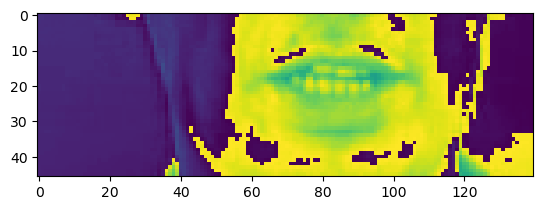

In [19]:
plt.imshow(frames[40])

In [20]:
alignments #raw representation

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23], dtype=int64)>

In [21]:
print([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]) 

['b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'l', ' ', 's', 'i', 'x', ' ', 'n', 'o', 'w']


In [22]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()]) #undoing transofrmations

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [23]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [24]:
from matplotlib import pyplot as plt #already imported but just to show that it relates in this section

In [25]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg') #looking for .mpg files
data = data.shuffle(500, reshuffle_each_iteration=False)  #random first 500
data = data.map(mappable_function) #returning frames and alignments
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))  # two videos in each batch
data = data.prefetch(tf.data.AUTOTUNE) #preloading as ml model is training
# Added for split 
train = data.take(450)
test = data.skip(450)

In [26]:
len(test)

50

In [29]:
frames, alignments = data.as_numpy_iterator().next() #there should be 2 video's frames and alignments as can be seen below

In [30]:
len(frames)

2

In [31]:
sample = data.as_numpy_iterator()

In [32]:
val = sample.next(); val[0]  #val[0] is returning frames

array([[[[[ 0.67056775],
          [ 0.98612905],
          [ 1.0255742 ],
          ...,
          [ 0.35500646],
          [ 0.3155613 ],
          [ 0.3155613 ]],

         [[ 0.35500646],
          [ 0.7100129 ],
          [ 0.7494581 ],
          ...,
          [ 0.35500646],
          [ 0.3155613 ],
          [ 0.3155613 ]],

         [[ 0.86779356],
          [ 1.0255742 ],
          [ 0.86779356],
          ...,
          [ 0.3155613 ],
          [ 0.27611613],
          [ 0.27611613]],

         ...,

         [[ 1.1439097 ],
          [ 1.1439097 ],
          [ 1.1439097 ],
          ...,
          [ 0.03944516],
          [ 0.03944516],
          [ 0.03944516]],

         [[ 1.0650194 ],
          [ 1.0650194 ],
          [ 1.0650194 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],

         [[ 1.0650194 ],
          [ 1.0650194 ],
          [ 1.0650194 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          

In [54]:
# Assuming val[0][0] is the array for the animation for this sample dataset
frames = val[0][0]

# Normalize the data to the range [0, 1], then scale to [0, 255]
frames = (frames - frames.min()) / (frames.max() - frames.min())  # Normalize to [0, 1]
frames = frames * 255  # Scale to [0, 255]

# Convert to uint8
frames = frames.astype(np.uint8)

# Remove extra dimensions (squeeze the grayscale channel)
frames = frames.squeeze(-1)

# Save the animation: converting numpy array to gif
imageio.mimsave('./animation.gif', frames, fps=10)

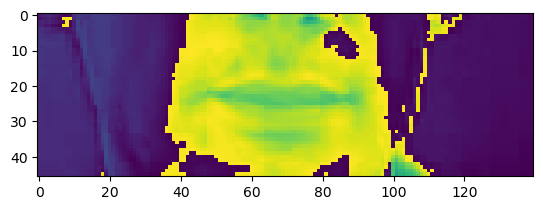

In [56]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][0])

In [57]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]]) #anotation for the video

<tf.Tensor: shape=(), dtype=string, numpy=b'bin red by a zero please'>

# 3. Design the Deep Neural Network

In [58]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [59]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

In [ ]:
5*17*75

In [ ]:
yhat = model.predict(val[0])

In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

In [ ]:
model.input_shape

In [ ]:
model.output_shape

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [ ]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

In [ ]:
model.load_weights('models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('.\\data\\s1\\bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]